# Simulate acoustic wave propagation with multiple domains


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook shows the functionality to perform acoustic simulations when multiple domains are present.

## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


In [4]:
optimus.global_parameters.print()


Verbosity parameter: False

Linear algebra parameters:
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None

Postprocessing parameters:
 Potential operator assembly type is:  h-matrix
 H-matrix epsilon for postprocessing operators: 1e-08
 H-matrix maximum rank for postprocessing operators: 10000
 H-matrix maximum block size for postprocessing operators: 10000


## Specify the physical settings for the simulation

Let us consider two spherical objects embedded in an unbounded region of water. One of the domains consists of fat and the other of cortical bone. The incident plane wave has a frequency of 100 kHz and the two spheres have a radius of 7 and 5 mm, respectively.

In [5]:
frequency = 200e3
source = optimus.source.create_planewave(frequency, direction=(1,0,0))

In [6]:
radii = (7e-3, 5e-3)
origins = ((-10e-3,0,0), (10e-3,0,0))
meshwidth = 2e-3

In [7]:
geometry_left = optimus.geometry.shapes.Sphere(radius=radii[0], origin=origins[0], element_size=meshwidth)
geometry_right = optimus.geometry.shapes.Sphere(radius=radii[1], origin=origins[1], element_size=meshwidth)
geometries = (geometry_left, geometry_right)

In [8]:
geometries[0].label

'sphere'

A list of materials can be loaded at once.

In [9]:
material_ext = optimus.material.load_material('water')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material_left, material_right = materials_int

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. The model with default settings needs the physical parameters as input. The interior domains are specified as a tuple or list of the geometries and the materials, while the exterior medium needs to be specified separately.

In [10]:
model = optimus.model.create_acoustic_model(source, geometries, material_ext, materials_int, 
                                            formulation='pmchwt',
                                            preconditioner='osrc')

Solving the model requires the GMRES algorithm to solve the system of boundary integral equations. This can be computationally expensive depending on the grid resolution.

In [11]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [12]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [13]:
# Create a visualisation grid
Nx = 61
Ny = 71
xmin, xmax, ymin, ymax = [20e-3, 30e-3, -15e-3, 20e-3]
zmin, zmax = [-1e-3,1e-3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j, zmin:zmax:Nx * 1j]
# points = np.vstack((plot_grid[0].ravel(),
#                     plot_grid[1].ravel(),
#                     zval*np.ones(plot_grid[0].size)))
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    plot_grid[2].ravel()))

In [14]:
points

array([[ 0.02      ,  0.02      ,  0.02      , ...,  0.03      ,
         0.03      ,  0.03      ],
       [-0.015     , -0.015     , -0.015     , ...,  0.02      ,
         0.02      ,  0.02      ],
       [-0.001     , -0.00096667, -0.00093333, ...,  0.00093333,
         0.00096667,  0.001     ]])

In [15]:
pp_2d = optimus.postprocess.PostProcess_2D(model)

In [48]:
pp_2d.create_computational_grid(resolution=[Nx,Ny], plane_axes=[0,1], 
                             plane_offset=0, bounding_box=[7e-3, 13e-3, -4e-3, 4e-3])


 Identifying the exterior and interior points Started at:  Mon, 04 Jul 2022 18:52:51
Element groups are:
[0]
Time to complete solid angle field parallelisation:  3.930473566055298
Element groups are:
[0]
Time to complete solid angle field parallelisation:  3.542797327041626

 Identifying the exterior and interior points Finished... Duration in secs:  7.549948215484619


../optimus/postprocess/concave_hull.py:44: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - a) * (s - b) * (s - c))


In [49]:
pp_2d.points_interior[1].any()

True

In [50]:
pp_2d.index_interior[0].any()

False

In [51]:
len(pp_2d.points_exterior)

3

In [52]:
pp_2d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Mon, 04 Jul 2022 18:52:59
Calculating the fields of Domain 1
(3, 0) (4331,) (872.5510125840678+0.7587801706029274j) <optimus.material.common.Material object at 0x7faf3a41f588>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  0.040053606033325195
Calculating the fields of Domain 2
(3, 4316) (4331,) (357.5215180479361+10.910599999999999j) <optimus.material.common.Material object at 0x7faf3a41f668>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  0.5445492267608643

 Calculating the incident field Started at:  Mon, 04 Jul 2022 18:53:00

 Calculating the incident field Finished... Duration in secs:  0.0002200603485107422


In [53]:
pp_2d.total_field.shape

(4331,)

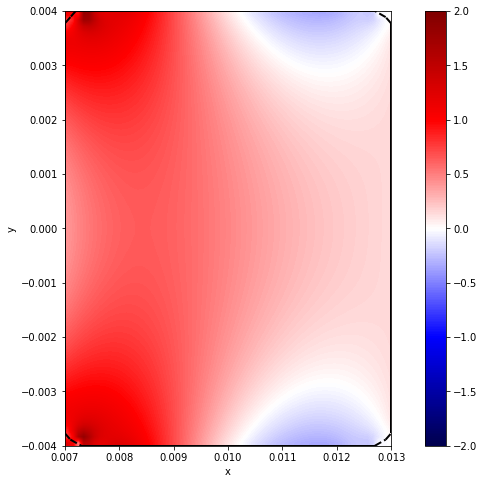

In [54]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(pp_2d.total_field_reshaped), extent=pp_2d.bounding_box, clim=(-2,2), cmap='seismic', 
           interpolation='bilinear')
if len(pp_2d.domains_edges):
    for i, j in pp_2d.domains_edges:
        plt.plot(i, j, color = 'black', linestyle='dashed' ,linewidth=2)
    
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

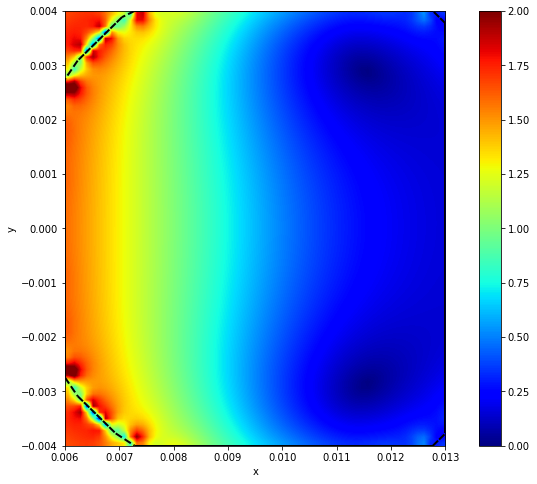

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.abs(pp_2d.total_field_reshaped), extent=pp_2d.bounding_box, clim=(0,2), cmap='jet', 
           interpolation='bilinear')
if len(pp_2d.domains_edges):
    for i, j in pp_2d.domains_edges:
        plt.plot(i, j, color = 'black', linestyle='dashed' ,linewidth=2)
    
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [24]:
# ppu_2d = optimus.postprocess.PostProcess_UserDefined(model,verbose=True)

In [25]:
# ppu_2d.create_computational_grid(resolution=[Nx,Ny],user_points=points)

In [26]:
# ppu_2d.compute_fields()

In [27]:
# fig = plt.figure(figsize=(12, 8))
# plt.imshow(np.real(ppu_2d.total_field_reshaped), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', 
#            interpolation='bilinear')
# theta = np.linspace(0, 2*np.pi, 100)
    
# plt.xlabel('x')
# plt.ylabel('y')
# plt.colorbar()
# plt.show()

In [28]:
ppu_3d = optimus.postprocess.PostProcess_UserDefined(model,verbose=True)

In [29]:
ppu_3d.create_computational_grid(user_points=pp_2d.points)


 Identifying the exterior and interior points Started at:  Mon, 04 Jul 2022 18:49:13
Element groups are:
[0]


../optimus/postprocess/method.py:213: RuntimeWarning: The user-defined points will be used for field calculations.
  RuntimeWarning,


Time to complete solid angle field parallelisation:  0.9020214080810547
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.0502357482910156

 Identifying the exterior and interior points Finished... Duration in secs:  2.0288398265838623


In [30]:
ppu_3d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Mon, 04 Jul 2022 18:49:15
Calculating the fields of Domain 1
(3, 4331) (4331,) (872.5510125840678+0.7587801706029274j) <optimus.material.common.Material object at 0x7faf3a41f588>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  0.7009694576263428
Calculating the fields of Domain 2
(3, 0) (4331,) (357.5215180479361+10.910599999999999j) <optimus.material.common.Material object at 0x7faf3a41f668>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  0.7051980495452881


In [31]:
ppu_3d.total_field

array([-0.67387238+0.60630504j, -0.67762134+0.60395965j,
       -0.68123207+0.60171894j, ...,  0.27688293-0.96528126j,
        0.27327661-0.9716223j ,  0.26981053-0.97796675j])

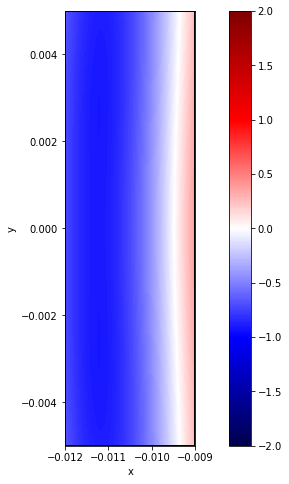

In [32]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.flipud(np.real(ppu_3d.total_field.reshape((pp_2d.resolution)).T)), extent=pp_2d.bounding_box, clim=(-2,2), cmap='seismic', 
           interpolation='bilinear')
if len(pp_2d.domains_edges):
    for i, j in pp_2d.domains_edges:
        plt.plot(i, j, color = 'black', linestyle='dashed' ,linewidth=2)
    
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [33]:
pp_3d = optimus.postprocess.PostProcess_3D(model,verbose=True)

In [34]:
pp_3d.create_computational_grid(plane_offset=-2e-3)


 Identifying the exterior and interior points Started at:  Mon, 04 Jul 2022 18:49:23
Element groups are:
[0]
Time to complete solid angle field parallelisation:  2.037593364715576
Element groups are:
[0]
Time to complete solid angle field parallelisation:  2.033020496368408

 Identifying the exterior and interior points Finished... Duration in secs:  4.984375


In [35]:
pp_3d.index_interior[0].any()

True

In [36]:
pp_3d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Mon, 04 Jul 2022 18:49:28
Calculating the fields of Domain 1
(3, 20130) (60520,) (872.5510125840678+0.7587801706029274j) <optimus.material.common.Material object at 0x7faf3a41f588>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  9.949142694473267
Calculating the fields of Domain 2
(3, 9981) (60520,) (357.5215180479361+10.910599999999999j) <optimus.material.common.Material object at 0x7faf3a41f668>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  16.290132999420166

 Calculating the incident field Started at:  Mon, 04 Jul 2022 18:49:44

 Calculating the incident field Finished... Duration in secs:  0.020134449005126953


In [37]:
np.isnan(pp_3d.total_field).any()

False

In [38]:
import bempp.api as bempp

In [39]:
bempp.export(file_name='test.msh', grid_function = bempp.GridFunction(space=bempp.function_space(pp_2d.points, "P", 1),coefficients=pp_2d.total_field))

AttributeError: 'numpy.ndarray' object has no attribute '_impl'